Data Augmentation

In [15]:
import numpy as np
from collections import OrderedDict
import logging
from mlp.layers import AffineLayer
from mlp.errors import CrossEntropySoftmaxError
from mlp.models import MultipleLayerModel
from mlp.initialisers import GlorotUniformInit, ConstantInit
from mlp.learning_rules import MomentumLearningRule
from mlp.data_providers import MNISTDataProvider
from mlp.optimisers import Optimiser
from mlp.data_providers import AugmentedMNISTDataProvider
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
from scipy.ndimage.interpolation import shift,affine_transform,zoom,rotate,geometric_transform
from mlp.layers import Layer

In [16]:
class ReluLayer(Layer):
    """Layer implementing an element-wise rectified linear transformation."""

    def fprop(self, inputs):
        """Forward propagates activations through the layer transformation.

        For inputs `x` and outputs `y` this corresponds to `y = max(0, x)`.
        """
        return np.maximum(inputs, 0.)

    def bprop(self, inputs, outputs, grads_wrt_outputs):
        """Back propagates gradients through a layer.

        Given gradients with respect to the outputs of the layer calculates the
        gradients with respect to the layer inputs.
        """
        return (outputs > 0) * grads_wrt_outputs

    def __repr__(self):
        return 'ReluLayer'
def random_shift(inputs, rng):
    orig_ims = inputs.reshape((-1, 28, 28))
    new_ims = orig_ims.copy()
    indices = rng.choice(orig_ims.shape[0], orig_ims.shape[0] // 4, False)
    shifts = rng.uniform(-1., 1., size=indices.shape[0]) * 2

    for i, j in enumerate(indices):
        new_ims[j] = shift(orig_ims[j], shifts[i], order=1)
    return new_ims.reshape((-1, 784))
def random_rotation(inputs, rng):
    orig_ims = inputs.reshape((-1, 28, 28))
    new_ims = orig_ims.copy()
    indices = rng.choice(orig_ims.shape[0], orig_ims.shape[0] // 4, False)
    angles = rng.uniform(-1., 1., size=indices.shape[0]) * 30.
    for i, j in enumerate(indices):
        new_ims[j] = rotate(orig_ims[j], angles[i], order=1, reshape=False)
    return new_ims.reshape((-1, 784))
def random_geometric_transform(inputs, rng):

    orig_ims = inputs.reshape((-1, 28, 28))
    new_ims = orig_ims.copy()
    indices = rng.choice(orig_ims.shape[0], orig_ims.shape[0] // 4, False)
    def shift_func(output_coords):
        return (output_coords[0]-1., output_coords[1]-1.0)
    for i, j in enumerate(indices):
        new_ims[j] = geometric_transform(orig_ims[j], shift_func, order=1)
    return new_ims.reshape((-1, 784))

In [17]:
# this cell is to test if my shift function works right, so no need to run this cell
# def show_batch_of_images(img_batch, fig_size=(3, 3)):
#     fig = plt.figure(figsize=fig_size)
#     batch_size, im_height, im_width = img_batch.shape
#     # calculate no. columns per grid row to give square grid
#     grid_size = int(batch_size**0.5)
#     # intialise empty array to tile image grid into
#     tiled = np.empty((im_height * grid_size, 
#                       im_width * batch_size // grid_size))
#     # iterate over images in batch + indexes within batch
#     for i, img in enumerate(img_batch):
#         # calculate grid row and column indices
#         r, c = i % grid_size, i // grid_size
#         tiled[r * im_height:(r + 1) * im_height, 
#               c * im_height:(c + 1) * im_height] = img
#     ax = fig.add_subplot(111)
#     ax.imshow(tiled, cmap='Greys') #, vmin=0., vmax=1.)
#     ax.axis('off')
#     fig.tight_layout()
#     plt.show()
#     return fig, ax

# test_data = MNISTDataProvider('test', 100, rng=rng)
# inputs, targets = test_data.next()

# _ = show_batch_of_images(inputs.reshape((-1, 28, 28)))
# transformed_inputs = random_shift(inputs, rng)
# transformed_inputs.shape
# _ = show_batch_of_images(transformed_inputs.reshape((-1, 28, 28)))

In [18]:
# Seed a random number generator
seed = 24102016 
rng = np.random.RandomState(seed)

# Set up a logger object to print info about the training run to stdout
logger = logging.getLogger()
logger.setLevel(logging.INFO)
logger.handlers = [logging.StreamHandler()]

num_epochs = 100
stats_interval = 5
batch_size = 50
learning_rate = 0.01
mom_coeff = 0.9
weights_init_gain = 0.5
biases_init = 0.

# Create data provider objects for the MNIST data set
train_data = MNISTDataProvider('train', batch_size, rng=rng)
valid_data = MNISTDataProvider('valid', batch_size, rng=rng)
input_dim, output_dim, hidden_dim = 784, 10, 100

weights_init = GlorotUniformInit(weights_init_gain, rng)
biases_init = ConstantInit(biases_init)
error = CrossEntropySoftmaxError()
learning_rule = MomentumLearningRule(learning_rate, mom_coeff)
data_monitors = {'acc': lambda y, t: (y.argmax(-1) == t.argmax(-1)).mean()}

In [19]:
###baseline
rng.seed(seed)
train_data.reset()
valid_data.reset()
    
model = MultipleLayerModel([
    AffineLayer(input_dim, hidden_dim, weights_init, biases_init),
    ReluLayer(),
    AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init),
    ReluLayer(),
    AffineLayer(hidden_dim, output_dim, weights_init, biases_init)
])
optimiser = Optimiser(model, error, learning_rule, train_data, valid_data, data_monitors)
run_info_baseline = optimiser.train(num_epochs, stats_interval)

Epoch 0:
  error(train)=2.30e+00, acc(train)=9.80e-02, error(valid)=2.30e+00, acc(valid)=1.05e-01, params_penalty=0.00e+00
Epoch 5: 1.05s to complete
  error(train)=6.34e-02, acc(train)=9.82e-01, error(valid)=9.67e-02, acc(valid)=9.72e-01, params_penalty=0.00e+00
Epoch 10: 1.10s to complete
  error(train)=2.36e-02, acc(train)=9.94e-01, error(valid)=8.34e-02, acc(valid)=9.77e-01, params_penalty=0.00e+00
Epoch 15: 1.16s to complete
  error(train)=8.49e-03, acc(train)=9.98e-01, error(valid)=8.34e-02, acc(valid)=9.78e-01, params_penalty=0.00e+00
Epoch 20: 1.15s to complete
  error(train)=3.42e-03, acc(train)=1.00e+00, error(valid)=9.58e-02, acc(valid)=9.78e-01, params_penalty=0.00e+00
Epoch 25: 1.14s to complete
  error(train)=1.42e-03, acc(train)=1.00e+00, error(valid)=9.48e-02, acc(valid)=9.79e-01, params_penalty=0.00e+00
Epoch 30: 1.13s to complete
  error(train)=9.06e-04, acc(train)=1.00e+00, error(valid)=1.01e-01, acc(valid)=9.79e-01, params_penalty=0.00e+00
Epoch 35: 1.15s to complet

In [20]:
batch_size = 100
num_epochs = 100
learning_rate = 0.01
mom_coeff = 0.9
stats_interval = 5

def augmentation_model(transformer):
    aug_train_data = AugmentedMNISTDataProvider('train', rng=rng, transformer=transformer)

    rng.seed(seed)
    aug_train_data.reset()
    valid_data.reset()
    aug_train_data.batch_size = batch_size 
    valid_data.batch_size = batch_size

    weights_init = GlorotUniformInit(0.5, rng=rng)
    biases_init = ConstantInit(0.)

    model = MultipleLayerModel([
        AffineLayer(input_dim, hidden_dim, weights_init, biases_init),
        ReluLayer(),
        AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init),
        ReluLayer(),
        AffineLayer(hidden_dim, output_dim, weights_init, biases_init)
    ])

    error = CrossEntropySoftmaxError()
    learning_rule = MomentumLearningRule(learning_rate=learning_rate, mom_coeff=mom_coeff)
    data_monitors={'acc': lambda y, t: (y.argmax(-1) == t.argmax(-1)).mean()}
    optimiser = Optimiser(
        model, error, learning_rule, aug_train_data, valid_data, data_monitors)

    aug_stats, aug_keys, aug_run_time = optimiser.train(
        num_epochs=num_epochs, stats_interval=stats_interval)
    
    return aug_stats, aug_keys, aug_run_time

In [21]:
aug_stats, aug_keys, aug_run_time = augmentation_model(random_rotation)

Epoch 0:
  error(train)=2.30e+00, acc(train)=9.99e-02, error(valid)=2.30e+00, acc(valid)=1.06e-01, params_penalty=0.00e+00
Epoch 5: 2.09s to complete
  error(train)=1.45e-01, acc(train)=9.57e-01, error(valid)=1.23e-01, acc(valid)=9.65e-01, params_penalty=0.00e+00
Epoch 10: 2.08s to complete
  error(train)=8.53e-02, acc(train)=9.74e-01, error(valid)=8.48e-02, acc(valid)=9.74e-01, params_penalty=0.00e+00
Epoch 15: 3.69s to complete
  error(train)=6.26e-02, acc(train)=9.81e-01, error(valid)=7.69e-02, acc(valid)=9.77e-01, params_penalty=0.00e+00
Epoch 20: 2.09s to complete
  error(train)=5.26e-02, acc(train)=9.85e-01, error(valid)=7.79e-02, acc(valid)=9.76e-01, params_penalty=0.00e+00
Epoch 25: 2.08s to complete
  error(train)=4.33e-02, acc(train)=9.88e-01, error(valid)=7.29e-02, acc(valid)=9.78e-01, params_penalty=0.00e+00
Epoch 30: 2.10s to complete
  error(train)=3.72e-02, acc(train)=9.89e-01, error(valid)=7.23e-02, acc(valid)=9.78e-01, params_penalty=0.00e+00
Epoch 35: 2.10s to complet

In [22]:
aug_stats1, aug_keys1, aug_run_time1 = augmentation_model(random_shift)

Epoch 0:
  error(train)=2.30e+00, acc(train)=9.98e-02, error(valid)=2.30e+00, acc(valid)=1.06e-01, params_penalty=0.00e+00
Epoch 5: 1.45s to complete
  error(train)=1.32e-01, acc(train)=9.61e-01, error(valid)=1.14e-01, acc(valid)=9.66e-01, params_penalty=0.00e+00
Epoch 10: 1.46s to complete
  error(train)=7.67e-02, acc(train)=9.78e-01, error(valid)=8.27e-02, acc(valid)=9.75e-01, params_penalty=0.00e+00
Epoch 15: 1.45s to complete
  error(train)=5.62e-02, acc(train)=9.84e-01, error(valid)=7.51e-02, acc(valid)=9.78e-01, params_penalty=0.00e+00
Epoch 20: 1.46s to complete
  error(train)=4.29e-02, acc(train)=9.87e-01, error(valid)=7.38e-02, acc(valid)=9.77e-01, params_penalty=0.00e+00
Epoch 25: 1.46s to complete
  error(train)=3.81e-02, acc(train)=9.90e-01, error(valid)=7.20e-02, acc(valid)=9.80e-01, params_penalty=0.00e+00
Epoch 30: 1.46s to complete
  error(train)=2.94e-02, acc(train)=9.92e-01, error(valid)=6.92e-02, acc(valid)=9.82e-01, params_penalty=0.00e+00
Epoch 35: 1.46s to complet

In [23]:
aug_stats2, aug_keys2, aug_run_time2 = augmentation_model(random_geometric_transform)

Epoch 0:
  error(train)=2.30e+00, acc(train)=9.51e-02, error(valid)=2.30e+00, acc(valid)=1.06e-01, params_penalty=0.00e+00
Epoch 5: 7.06s to complete
  error(train)=1.36e-01, acc(train)=9.60e-01, error(valid)=1.33e-01, acc(valid)=9.62e-01, params_penalty=0.00e+00
Epoch 10: 7.53s to complete
  error(train)=7.02e-02, acc(train)=9.80e-01, error(valid)=9.06e-02, acc(valid)=9.73e-01, params_penalty=0.00e+00
Epoch 15: 7.05s to complete
  error(train)=4.91e-02, acc(train)=9.86e-01, error(valid)=7.86e-02, acc(valid)=9.77e-01, params_penalty=0.00e+00
Epoch 20: 7.06s to complete
  error(train)=3.39e-02, acc(train)=9.91e-01, error(valid)=7.79e-02, acc(valid)=9.78e-01, params_penalty=0.00e+00
Epoch 25: 7.05s to complete
  error(train)=2.98e-02, acc(train)=9.92e-01, error(valid)=8.06e-02, acc(valid)=9.77e-01, params_penalty=0.00e+00
Epoch 30: 7.05s to complete
  error(train)=2.53e-02, acc(train)=9.92e-01, error(valid)=8.49e-02, acc(valid)=9.77e-01, params_penalty=0.00e+00
Epoch 35: 7.06s to complet

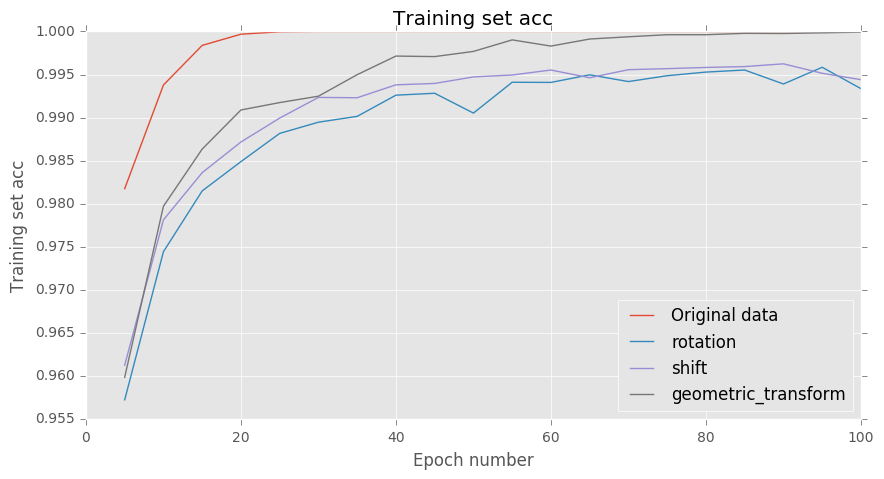

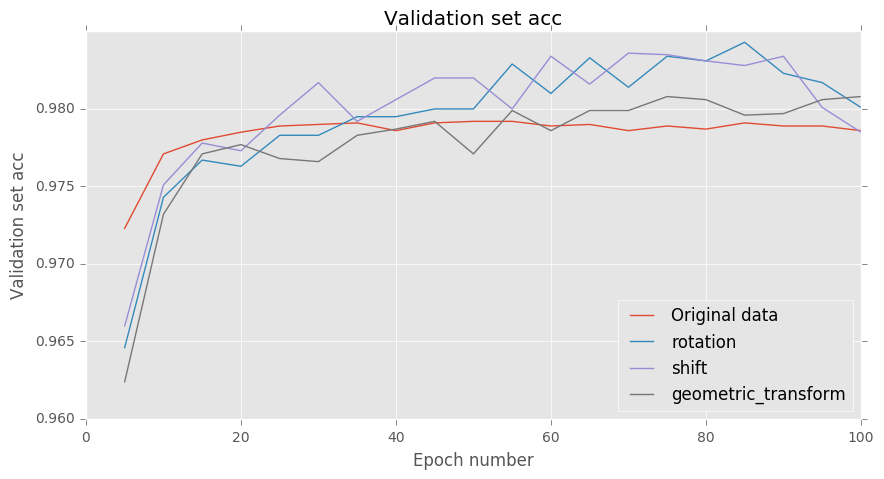

In [30]:
stats, keys, run_time = run_info_baseline
fig_1 = plt.figure(figsize=(10, 5))
ax_1 = fig_1.add_subplot(111)
ax_1.plot(np.arange(1, stats.shape[0]) * stats_interval, 
             stats[1:, keys['acc(train)']], label='Original data')
ax_1.plot(np.arange(1, aug_stats.shape[0]) * stats_interval, 
             aug_stats[1:, aug_keys['acc(train)']], label='rotation')      
ax_1.plot(np.arange(1, aug_stats1.shape[0]) * stats_interval, 
             aug_stats1[1:, aug_keys1['acc(train)']], label='shift')  
ax_1.plot(np.arange(1, aug_stats2.shape[0]) * stats_interval, 
             aug_stats2[1:, aug_keys2['acc(train)']], label='geometric_transform')  
ax_1.legend(loc=0)
ax_1.set_xlabel('Epoch number')
ax_1.set_ylabel('Training set acc')
plt.title("Training set acc")


fig_2 = plt.figure(figsize=(10, 5))
ax_2 = fig_2.add_subplot(111)

ax_2.plot(np.arange(1, stats.shape[0]) * stats_interval, 
             stats[1:, keys['acc(valid)']], label='Original data')
ax_2.plot(np.arange(1, aug_stats.shape[0]) * stats_interval, 
             aug_stats[1:, aug_keys['acc(valid)']], label='rotation')
ax_2.plot(np.arange(1, aug_stats1.shape[0]) * stats_interval, 
             aug_stats1[1:, aug_keys1['acc(valid)']], label='shift')
ax_2.plot(np.arange(1, aug_stats2.shape[0]) * stats_interval, 
             aug_stats2[1:, aug_keys2['acc(valid)']], label='geometric_transform')

ax_2.legend(loc=0)
ax_2.set_xlabel('Epoch number')
ax_2.set_ylabel('Validation set acc')
plt.title("Validation set acc")